# 1k3f 30 C High Pressure


### Scaling Time

We scale time in this version of the analysis by a multiplicative factor to ensure that the time between the start time and the measurement time (time-stamped on the images) is equal to the final time listed on the axis of the Belsorp plot. I've estimated this factor to be around 16/15, but I will compute it precisely in the following analysis. This scaling differs from the previous approach by scaling time by a multiplicative factor instead of shifting it.

### Description of Experiment

We are characterizing the sorption of CO2 in the trifunctional 1k3f polyol at 30 C to understand the effect of functionality on sorption. The experiment was performed with manual pressure changes and used DataThief on the plot generated by the Belsorp BG software to extra gravimetry data. 

The polyol is trifunctional with molecular weight ~1000 g/mol in an atmosphere of carbon dioxide and was provided by Dow Chemical in Colombia. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from August 1-9, 2019.
    
The analysis computes the **solubility, interfacial tension, and specific volume** of the sample at pressures from 0 to 60 bar at 30.5 C. No diffusivity data are provided because of the lack of reliable time-series data at either the beginning or the end of the sorption curve due to large fluctuations in temperature (which have a magnified effect at higher pressure). Unfortunately, higher pressures could not be probed because the pendant drop necked and fell at 62 bar (6.2 MPa).

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import glob
import os
from scipy.interpolate import interp1d

import dataproc
from timedate import TimeDate

from importlib import reload
reload(dataproc)

file_template = '20190*_*_*kPa*'
metadata_file = '20190801_0809_1k3f_30c_metadata.txt'
# folder for gravimetry data from DataThief analysis of Belsorp BG data plotted from Rubotherm
datathief_folder = '../../EXPERIMENTS/Italy/data/datathief/20190801_0809_1k3f_30c/'
grav_folder = '../../EXPERIMENTS/Italy/data/gravimetry/'
date_ref = '8/01/2019'
time_ref = '17:42:00'
# system parameters
polyol = '1k3f' # polyol code name indicating 1 kg/mol molecular weight and a functionality of 3
# set point temperature [C]
T = 30.5
# index of 110 kPa, roughly equivalent to atmospheric pressure (note that this is atmospheric pressure of CO2)
i_110kPa = -1

p_filepath_template = os.path.join(datathief_folder + file_template + '_p.txt')
p_file_list = glob.glob(p_filepath_template)
T_filepath_template = os.path.join(datathief_folder + file_template + '_T.txt')
T_file_list = glob.glob(T_filepath_template)
mp1_filepath_template = os.path.join(datathief_folder + file_template + '_mp1.txt')
mp1_file_list = glob.glob(mp1_filepath_template)

# initialize numpy arrays to store measured values (time,pressure, temperature, and MP1 balance reading)
t_grav = []
p_list = []
T_list = []
br_list = []
bp_list = []
time_list = []
date_list = []
# load metadata
metadata = pd.read_csv(datathief_folder + metadata_file, header=0)

# create reference date and time object
time_date_ref = TimeDate()
time_date_ref.load_string(date_ref, time_ref)
# load data from each file
for i in range(len(p_file_list)):
    # extract filepaths for pressure, temperature, and MP1 balance reading
    p_file = p_file_list[i]
    T_file = T_file_list[i]
    mp1_file = mp1_file_list[i]
    # load data
    t_p, p = dataproc.load_datathief_data(p_file)
    if i == 2:
        print(t_p[-1])
        
    t_T, T_ = dataproc.load_datathief_data(T_file)
    t_mp1, mp1 = dataproc.load_datathief_data(mp1_file)

    # remove repeats and interpolate values so spacing is even [min]
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2)
       
    # identify pressure step as a reference point in time to synchronize different runs
    t_mult = dataproc.compute_t_multiplier(metadata, i, t_p_interp, date_ref, time_ref)

    # TODO check if the automated computation gives an accurate multiplier for t
    print('t_mult = %f' % t_mult)
    t_mult = 1.058
    
    # synchronize times of all measurements using only times that overlap [min]
    t_min = np.max([np.min(t_p), np.min(t_T), np.min(t_mp1)])
    t_max = np.min([np.max(t_p), np.max(t_T), np.max(t_mp1)])
    # remove repeats and interpolate values so spacing is even (all interpolated times should be the same)
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2, t_min=t_min, t_max=t_max)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2, t_min=t_min, t_max=t_max)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2, t_min=t_min, t_max=t_max)
    
    # scale time
    t_p_interp *= t_mult
    # concatenate data
    dataproc.concatenate_data(metadata, i, date_ref, time_ref, time_list, date_list, 
                     t_grav, t_p_interp, p_interp, p_list, T_interp, T_list, 
                     mp1_interp, br_list, bp_list)
    
# save results in TRD file format consistent with that of Maria Rosaria Di Caprio
df_trd = pd.DataFrame(columns=['DATE', 'TIME', 'Julabo_Ext_PV', 'WEITGHT(g)', 'BALANCE POSITION', 'Now Pressure(kPa)'])
df_trd['DATE'] = date_list
df_trd['TIME'] = time_list
df_trd['Julabo_Ext_PV'] = T_list
df_trd['WEITGHT(g)'] = br_list
df_trd['BALANCE POSITION'] = bp_list
df_trd['Now Pressure(kPa)'] = p_list
trd_save_hdr = grav_folder + '%s_%dc-TRD-080119-1742' % (polyol, T)

# save csv file with TRD header
dataproc.save_trd(df_trd, trd_save_hdr)

t_mult = 1.075346
t_mult = 1.060621
5217.0
t_mult = 1.058104
t_mult = 1.057711
t_mult = 1.058136
t_mult = 1.057389
t_mult = 1.057527
t_mult = 1.057660
t_mult = 1.057535
t_mult = 1.057643
t_mult = 1.058027
t_mult = 1.057294
t_mult = 1.057534
t_mult = 1.057709
t_mult = 1.057370


Having created an artificial TRD file in the format that would have been produced by the Belsorp program during an automatic test, we can now proceed through the analysis as usual.

In [2]:
import errprop
import plot

reload(dataproc)
reload(errprop)

# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/20190801_0809_1k3f_30c/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190801_0803_1k3f_30c.csv', '20190805_0806_1k3f_30c.csv', '20190806_0808_1k3f_30c.csv',
                        '20190808_0809_1k3f_30c.csv']
# list of data files with interfacial tension data--leave blank if not complete
adsa_if_tension_file_list = ['20190801_0803_1k3f_30_if_tension.csv', '20190805_0806_1k3f_30_if_tension.csv',
                            '20190806_0808_1k3f_30c_if_tension.csv']
# filepath to gravimetry data 
grav_filepath = trd_save_hdr + '.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '1k3f_30c.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
adsa_time_list = ['17:41:00', '13:35:00', '18:42:00', '9:16:00']
adsa_date_list = ['8/01/2019', '8/05/2019', '8/06/2019', '8/08/2019']
# number of minutes of measurements to average for surface tension and volume readings
n_minutes = 90
# number of measurements to average (if the method using minutes doesn't work)
n_adsa = 20

# volume of drop in atmospheric pressure, from 20190801_1k3f_32c_1bar_snapshot.mdb [uL]
v_drop_atm = 3.59
# uncertainty in drop volume at atmospheric pressure [uL]
s_v_drop_atm = 0.015
# volume of drop in atmospheric pressure of CO2 from the average of the last 6 datapoints of 20190808_0809_1k3f_30c.csv [uL]
v_fallen_drop_atm = 0.8922
# volume of drop under vacuum (actually 20 kPa) around 10am 8/2/19 = 16h 20m in = 58,800 s of ADSA time
# --> from image 198 of 20190801_0803_1k3f_30c.csv [uL]
v_drop_0 = 3.587
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS)
# and extrapolated using CP-1000 Dow data (3 functional, 30.5 C by interpolating between 25 C and 50 C data) [g/mL]
rho_samp_atm = 1.0107
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]
# measurements at zero pressure (actually ~20 kPa) made manually with Rubotherm on 8/2/19 at 33 C
mp1_0 = 13.6229 # 20190802_1000_1k3f_20kPa_33c_mp1.txt [g]
zero_0 = 5.63582 # from 20190802_1001_1k3f_20kPa_33c_zero.png [g]
# measurements at just above atmospheric pressure made at the end with Rubotherm on 8/1/19 at 32 C
mp1_atm = 13.61709 # [g]
zero_atm = 5.63251 # [g]
# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = metadata['p set [kPa]'].to_numpy(dtype=float)
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# resolution of pressure measurement [kPa]
p_resolution = 1
# number of measurements of pressure within equilibrium (2 min per measurement --> 30 minutes, 2-3 cycles of temperature,
# which fluctuated every 10-15 minutes.)
n_p_eq = 50

# CONSTANTS
# atmospheric pressure [kPa]
P_ATM = 101.3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + dataproc.rho_co2(P_ATM, T)*v_ref_he 

# weight of sample in atmospheric pressure, using Rubotherm and subtracting tare mass (crucible, etc.) [g]
w_samp_atm = (mp1_atm - zero_atm) - TARE

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

We first compute the time delay from the reference time of the experiment (roughly the beginning) to the beginning of each ADSA measurement.

In [3]:
# initialize list of time delays until the start of the ADSA measurements
adsa_t0_list = []
# use TimeDate class to compute seconds of delay between the times and dates provided
for i in range(len(adsa_time_list)):
    adsa_time = adsa_time_list[i]
    adsa_date = adsa_date_list[i]
    adsa_td = TimeDate(date_str=adsa_date, time_str=adsa_time)
    # compute seconds after reference time that ADSA was started
    adsa_t0_list += [TimeDate.diff_min(time_date_ref, adsa_td)*60]

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [4]:
reload(dataproc)
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, 
                                                                      adsa_t0_list, grav_filepath, p_set_arr, zero_t_grav=False,
                                                                          time_date_ref=time_date_ref)
# convert times from seconds to minutes
t_adsa /= 60
t_grav = t_grav / 60.
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,specific volume [mL/g],specific volume (fit) [mL/g],specific volume error [mL/g],specific volume error (stat) [mL/g],specific volume error (sys) [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (sqrt) std [cm^2/s],diffusivity (exp) [cm^2/s],diffusivity (exp) std [cm^2/s],diffusion time constant [s]
0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot Drop Volume over Time Alongside Pressure

To determine if the gravimetry and ADSA data are accurately synchronized, I will plot the drop volume alongside the pressure. Changes in pressure should be quickly followed by the appropriate change in drop volume.

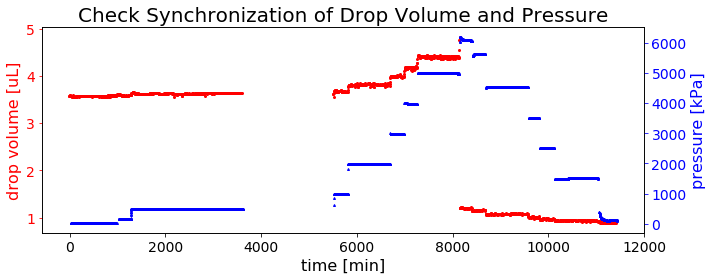

In [5]:
reload(plot)
plot.plot_two_axes(t_adsa, v_drop, p_arr, x2=t_grav, figsize=(10,4), labels=['drop vol', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='Check Synchronization of Drop Volume and Pressure')

## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 20 kPa.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Drop volume = 3.583467 uL.
Pressure = 150 kPa.
Rejected 1 outliers.
Drop volume = 3.588200 uL.
Pressure = 500 kPa.
Rejected 1 outliers.
Drop volume = 3.640800 uL.
Pressure = 1000 kPa.
Rejected 1 outliers.
Drop volume = 3.666067 uL.
Pressure = 2000 kPa.
Rejected 1 outliers.
Drop volume = 3.832800 uL.
Pressure = 3000 kPa.
Rejected 1 outliers.
Drop volume = 3.980000 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.
Drop volume = 4.169733 uL.
Pressure = 5000 kPa.
Rejected 1 outliers.
Drop volume = 4.405667 uL.
Pressure = 6100 kPa.
Rejected 1 outliers.
Drop volume = 1.198067 uL.
Pressure = 5600 kPa.
Rejected 1 outliers.
Drop volume = 1.158467 uL.
Pressure = 4500 kPa.
Rejected 1 outliers.
Drop volume = 1.075400 uL.
Pressure = 3500 kPa.
Rejected 1 outliers.
Drop volume = 1.010033 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.
Drop volume = 0.965927 uL.
Pressure = 1500 kPa.
Rejected 1 outliers.
Drop volume = 0.933600 uL.
Pressure = 110 kPa.
Rejected 1 outliers.
Drop volume = 0.889187 uL.


,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,specific volume [mL/g],specific volume (fit) [mL/g],specific volume error [mL/g],specific volume error (stat) [mL/g],specific volume error (sys) [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (sqrt) std [cm^2/s],diffusivity (exp) [cm^2/s],diffusivity (exp) std [cm^2/s],diffusion time constant [s]
0,20.0,17.4396,1,5.63582,1e-05,13.6222,0.000389703,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,150.0,151.945,1,5.63408,1e-05,13.6155,0.000370381,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500.0,494.801,1,5.62838,1e-05,13.596,0.00112187,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.0,997.566,1,5.62176,1e-05,13.5702,0.00194004,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000.0,1986.48,1,5.60279,1e-05,13.5082,0.00456975,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


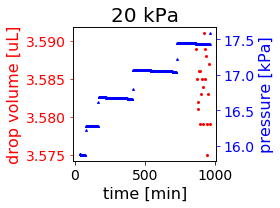

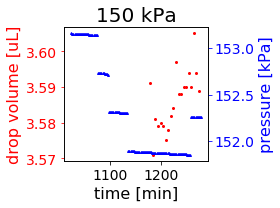

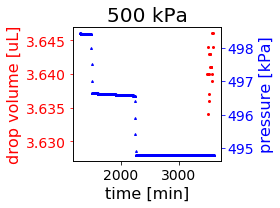

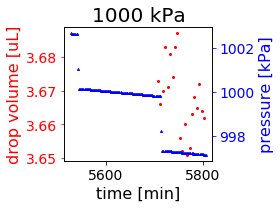

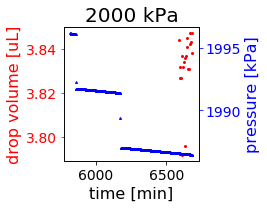

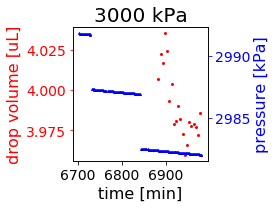

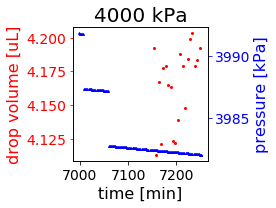

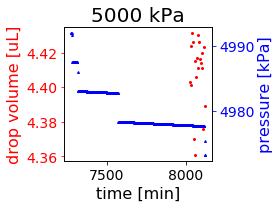

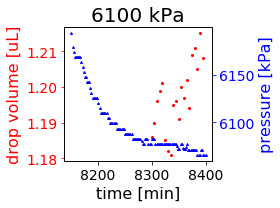

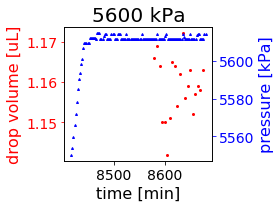

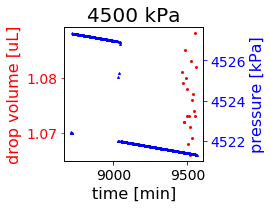

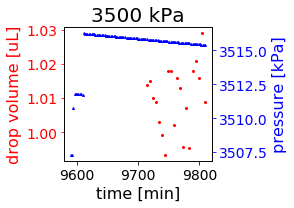

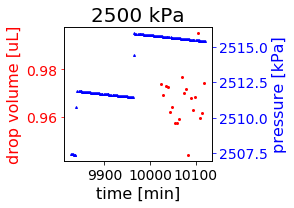

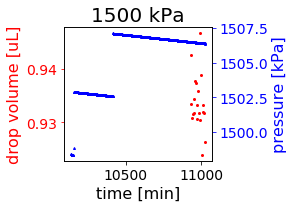

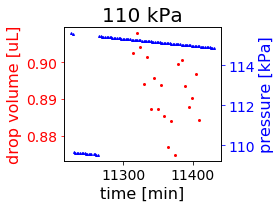

In [6]:
reload(dataproc)
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization
# initalize marker for pressure bounds
i_p1 = 0
# alternative fraction threshold for pressure window to identify data within a single pressure step
p_thresh_frac_alt = 0.2
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    if p_set == np.min(p_set_arr):
        # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac_alt, last_bound=i_p1, window_reduction=1)
    else:
        # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1, window_reduction=0.25)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = max(np.std(p_eq), p_resolution)
    # store results in data frame
    # use times to determine indices of ADSA to use
    i_adsa = dataproc.get_inds_adsa(t_adsa, t_grav, i_p0, i_p1, n_adsa)
    plot.plot_two_axes(t_adsa[i_adsa], v_drop[i_adsa], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['drop vol', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='%d kPa' % p_set)

    df = dataproc.store_grav_adsa_manual(df, metadata, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_minutes, n_p_eq,
                                        date_ref, time_ref, ref_by_dp=False)

df.head()

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must compute the mass and volume of the polymer under vacuum. Since I did not take a measurement with the balance under vacuum, I will extrapolate the balance reading using measurements made at atmospheric pressure and 50 kPa, assuming a linear change in the balance reading at such low pressures.

In [7]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# (extract value at 110 kPa) [g]
br_eq_atm = br_eq[i_110kPa]
# balance reading at 0 kPa [g]
br_eq_0 = mp1_0 - zero_0

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere by subtracting extrapolated balance reading at 0 kPa
w_gas_atm = (br_eq_atm - br_eq_0) + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %.5f g vs. mass of polymer at atmospheric pressure = %.5f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 0.69133 g vs. mass of polymer at atmospheric pressure = 0.70206 g.
Dry polymer mass estimated using tare measurement = 0.7045570066403526 g.
Volume of dry polymer in crucible is approximately ~ 0.694044 mL (using atmospheric density).


### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [8]:
reload(errprop)

# set parameters for error propagation
n = len(p_set_arr)
w_poly_arr = w_poly*np.ones([n])
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_atm*np.ones([n]) # volume of drop at atmospheric pressure [uL]
s_v_drop_ref = s_v_drop_atm*np.ones([n]) # variation of 0.03 uL by changing the position of the bottom of the rod--certain within half of it
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)
s_zero = df['zero std [g]'].to_numpy(dtype=float)
s_w_gas_ref = 0.00001*np.ones([n]) # uncertainty in weight measured by Rubotherm = resolution of Rubotherm [g]

### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

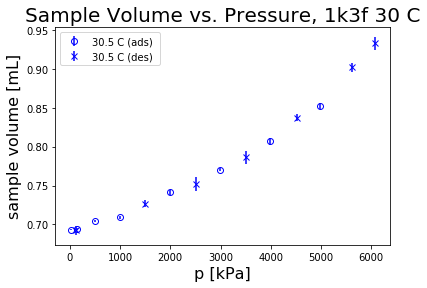

In [11]:
reload(plot)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
s_v_drop_eq = df['drop volume std [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
# adjust for fallen drop by using fallen drop volume at atmospheric pressure as reference volume 
i_drop_fallen = np.where(p_set_arr == np.max(p_set_arr))[0][0]
v_samp[i_drop_fallen:] = v_drop_eq[i_drop_fallen:] / v_fallen_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# extract data to plot (rough estimate)
err_drop_vol_min = 0.05
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
err_drop_vol = np.array([max(s_v_drop_eq[i], err_drop_vol_min) for i in range(len(s_v_drop_eq))])
s_v_samp = s_v_drop_eq/v_drop_eq*v_samp
df['sample volume std [mL]'] = s_v_samp
# plot equilibrium drop volume vs. p (red color for high temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_samp, s_v_samp, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='sample volume [mL]', title='Sample Volume vs. Pressure, %s %d C' % (polyol, T))

if save_plots:
    plt.savefig(save_folder + 'sample_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Fitting Sample Volume to Quadratic Curve to Reduce Error in Specific Volume

Prof. Di Maio suggested fitting the sample volume to a quadratic curve to reduce uncertainty introduced by experimental errors. By reducing uncertainty in the sample volume, we reduce the uncertainty in the specific volume measurement, which is too high to distinguish any non-monotonic trend in the pressure that we might expect (a variation of about 5% based on the PCL/CO2 paper by Carbone et al. (2012) *J. Supercrit. Fl.*
Previous analysis notebooks directly fit the quadratic curve to the drop volume, but because the drop volume is drastically affected by the falling of the drop, we must fit the sample volume directly.
This method greatly reduces the statistical error but the errors are smaller than the systematic error.

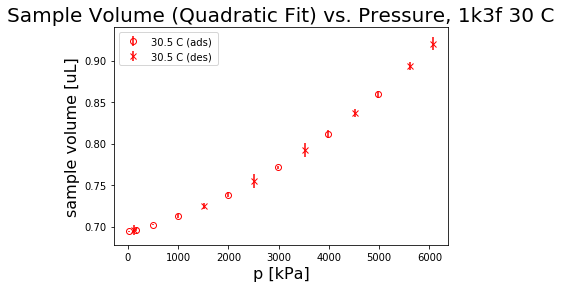

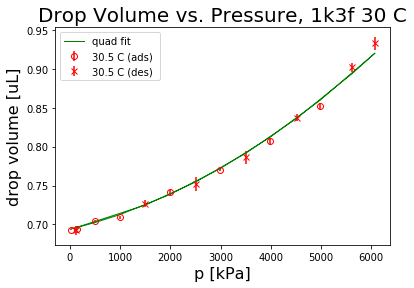

In [12]:
reload(dataproc)
# Compute fitted sample volume and uncertainty [uL]
v_samp_fit, s_v_samp_fit = dataproc.fit_v_drop(p_plot, v_samp, s_v_samp)

# plot fitted sample volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_samp_fit, s_v_samp_fit, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='sample volume [uL]', title='Sample Volume (Quadratic Fit) vs. Pressure, %s %d C' % (polyol, T))

# plot estimated sample volume vs. p alongside the fit (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_samp, s_v_samp, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_plot, v_samp_fit, ax=ax, marker=None, lw=1, color='g', label='quad fit')
plt.legend()

# use fit to estimate sample volume due to missing drop volume at low pressures during desorption
df['sample volume (fit) [mL]'] = v_samp_fit
df['sample volume (fit) std [mL]'] = s_v_samp_fit

To compare with the previous 3k2f 60 C test, I will plot the percent of swelling of each test below.

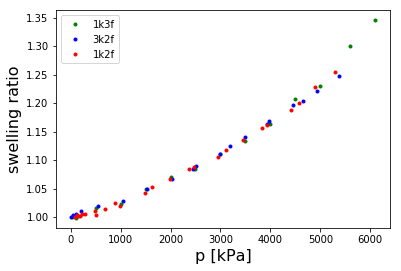

In [13]:
v_swell = df['sample volume [mL]'] / df['sample volume [mL]'].iloc[0]
ax = plot.plot_line(p_set_arr, v_swell, lw=0, color='g', label='1k3f', xlabel='p [kPa]', ylabel='swelling ratio')

# plot 3k2f at 31 c
df_3k2f = pd.read_csv('..\\g-adsa_results\\3k2f_31c.csv')
p_3k2f = df_3k2f['p actual [kPa]'].to_numpy(dtype=float)
v_drop_3k2f = df_3k2f['drop volume [uL]'].to_numpy(dtype=float)
v_swell_3k2f = v_drop_3k2f / v_drop_3k2f[0]
ax = plot.plot_line(p_3k2f, v_swell_3k2f, lw=0, color='b', ax=ax, label='3k2f')

# plot 1k2f at 30.5 c
df_1k2f = pd.read_csv('..\\g-adsa_results\\1k2f_30c.csv')
p_1k2f = df_1k2f['p actual [kPa]'].to_numpy(dtype=float)
v_drop_1k2f = df_1k2f['drop volume [uL]'].to_numpy(dtype=float)
# first drop volume is nan (not available) so I'm using the last drop volume, which is roughly at atmospheric pressure
v_swell_1k2f = v_drop_1k2f / v_drop_1k2f[-1]
ax = plot.plot_line(p_1k2f, v_swell_1k2f, lw=0, color='r', ax=ax, label='1k2f')
plt.legend()

The percent swelling seems to match best for 1k3f and 3k2f! Curious...even with different functionality and molecular weight.
Nevertheless, there is one notable outlier around 4500 kPa, probably a result of overestimating the drop volume in the FTA32 software.

### Correcting for Pressure Fluctuations

At higher pressures, the fluctuations in the temperature of the cell (about 0.1-0.2 C) caused by the cycle of the air conditioning system in the laboratory can cause significant fluctuations in the measuring point 1 (MP1) balance reading. To correct for these fluctuations, I will perform a "live" buoyancy correction at each data point.

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 20 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 150 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6100 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5600 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 110 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


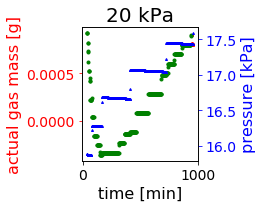

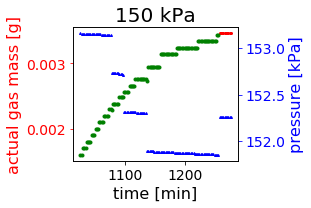

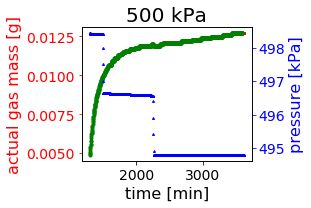

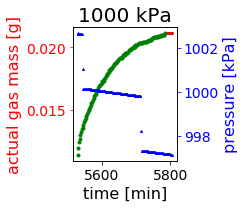

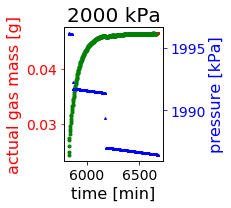

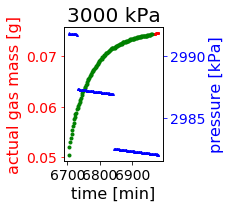

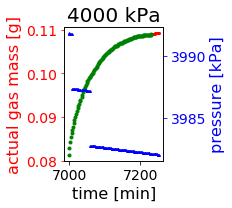

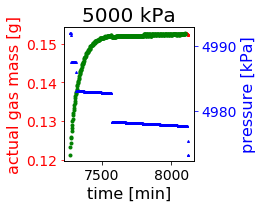

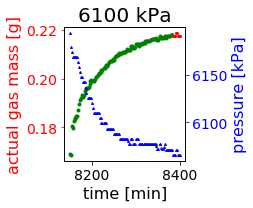

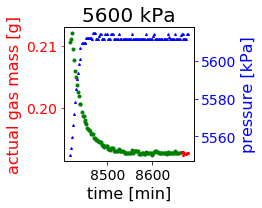

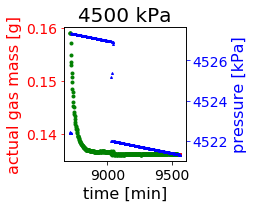

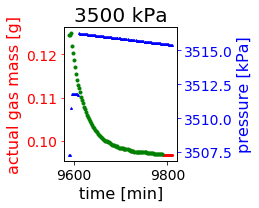

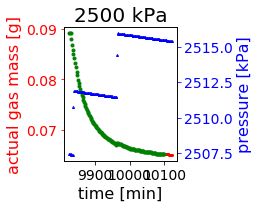

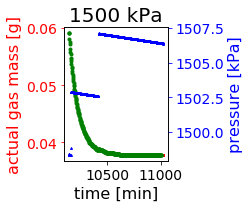

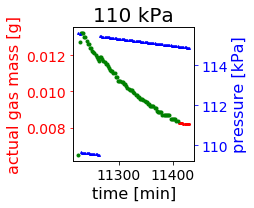

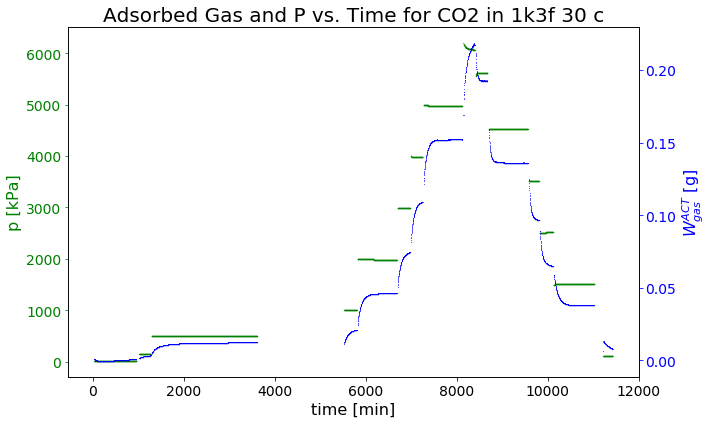

In [14]:
reload(plot)
reload(dataproc)
# parameters to insert at beginning
n_minutes = 20
# initalize marker for pressure bounds
last_bound = 0
# initialize arrays to store data
t_mp1_arr = np.array([])
w_gas_act_arr = np.array([])
p_mp1_arr = np.array([])
# set default mass of gas adsorbed in polyol to 0 and uncertainty to that of reference measurement [g]
df['M_0 (prev) [g]'] = np.zeros([len(p_set_arr)])
df['M_0 (prev) [g]'].iloc[0] = w_samp_atm - w_poly # initial mass at 0 pressure is difference of atm mass and dry mass [g]
df['M_0 (prev) std [g]'] = s_w_gas_ref[0]*np.ones([len(p_set_arr)])

# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # use a higher threshold on the fractional pressure fluctuation for 20 kPa
    if p_set == 20:
        p_thresh_frac_20 = 0.1
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac_20, last_bound=last_bound)
        # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
        w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                            t_grav, p_thresh_frac_20, last_bound, v_ref_he, 
                                                                            get_inst_buoy=True, t_eq=n_minutes)
    else:
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
        # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
        w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                            t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                            get_inst_buoy=True, t_eq=n_minutes)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
    
    t_mp1_arr = np.concatenate((t_mp1_arr, t_mp1))
    w_gas_act_arr = np.concatenate((w_gas_act_arr, w_gas_act))
    p_mp1_arr = np.concatenate((p_mp1_arr, p_mp1))
    # get indices to average the last X number of minutes
    inds_eq = np.where(t_mp1[-1] - t_mp1 <= n_minutes)[0]
    inds_trans = np.where(t_mp1[-1] - t_mp1 > n_minutes)[0]
    w_gas_act_eq = df['actual weight of dissolved gas [g]'].iloc[i]
    s_w_gas_act_eq = max(df['actual weight of dissolved gas std [g]'].iloc[i], s_w_gas_ref[0])
    # save new uncertainty
    df['actual weight of dissolved gas std [g]'].iloc[i] = s_w_gas_act_eq
    
    # plot dissolved gas for each pressure on same plot
    ax = plot.plot_two_axes(t_mp1[inds_eq], w_gas_act[inds_eq], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['gas mass', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['actual gas mass [g]', 'pressure [kPa]'], title='%d kPa' % p_set)
    plot.plot_line(t_mp1[inds_trans], w_gas_act[inds_trans], color='g', ax=ax)   
    
    # save gas mass from current run for next M_0 and uncertainty
    if i < len(p_set_arr)-1:
        df['M_0 (prev) [g]'].iloc[i+1] = w_gas_act_eq 
        df['M_0 (prev) std [g]'].iloc[i+1] = s_w_gas_act_eq 
    # save gas mass from current run for current M_infty and uncertainty
    df['M_infty (final) [g]'].iloc[i] = w_gas_act_eq 
    df['M_infty (final) std [g]'].iloc[i] = s_w_gas_act_eq 
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue

# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_mp1_arr, p_mp1_arr, w_gas_act_arr, markers=['o', '^'], labels=['p', r'$w_{gas}$'], figsize=(10,6),
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=['g', 'b'], ms=0.2,
                       xlabel='time [min]', ylabels=['p [kPa]', r'$W_{gas}^{ACT}$ [g]'])


# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

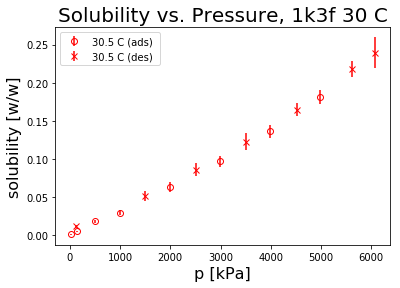

In [15]:
# COMPUTE AND PLOT SOLUBILITY
reload(errprop)
reload(dataproc)
reload(plot)

# load "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_gas_act = df['actual weight of dissolved gas [g]'].to_numpy(dtype=float)
# load buoyancy correction 
buoyancy = df['buoyancy correction [g]'].to_numpy(dtype=float)
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility, v_samp, buoyancy, w_gas_act, v_drop_eq, 
                                    s_v_drop_eq,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Previous Data

Since we have already measured the solubility of 3k2f at 60 C for pressures up to almost 5.5 MPa, we can explore the repeatability of these experiments by comparing our previous measurements with the present measurements.

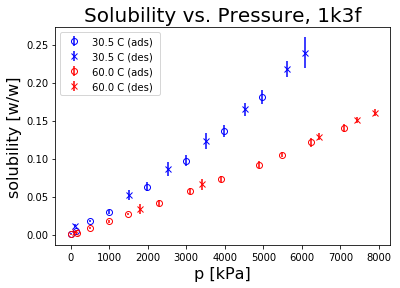

In [16]:
reload(plot)
# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s' % (polyol))
df_prev = pd.read_csv('..\\g-adsa_results\\1k3f_60c.csv')
p_prev = df_prev['p actual [kPa]'].to_numpy(dtype=float)
solubility_prev = df_prev['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_prev = df_prev['solubility error [w/w]'].to_numpy(dtype=float)
ax = plot.plot_errorbars_ads_des(p_prev, solubility_prev, s_solubility_prev, p_prev, 60, ax=ax, color='r')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_60c.pdf' % (polyol, T), bbox_inches='tight')

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

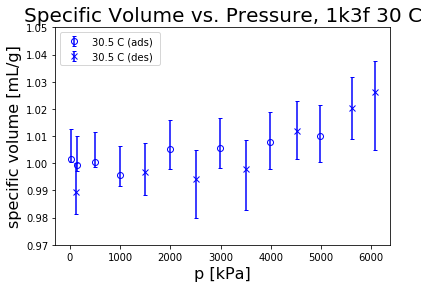

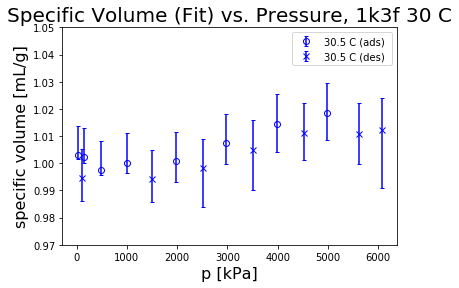

In [17]:
reload(errprop)

# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol
# also compute the specific volume based on the quadratic fit of the drop volume
spec_vol_fit = v_samp_fit / (w_gas_act + w_poly)
df['specific volume (fit) [mL/g]'] = spec_vol_fit

# propagate error to estimate uncertainty, distinguishing statistical and systematic
# biggest source of error in s_spec_vol is s_v_samp / v_samp by at least one order of magnitude
# within that, the biggest errors were from s_v_drop_ref / v_drop_ref and s_v_samp_ref / v_samp_ref
# the former was reduced by paying close attention to the volume measurement of the drop
# the biggest source of the latter is s_rho_samp_ref / rho_samp_ref
s_spec_vol_stat, s_spec_vol_sys = errprop.error_spec_vol_stat_sys(spec_vol, v_samp, buoyancy, w_gas_act, 
                                                                  v_drop_eq, s_v_drop_eq,  w_poly_arr, 
                                                                  s_frac_rho_co2, w_samp_ref, s_w_samp_ref, rho_samp_ref, 
                                                                  s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                                                  v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
# save separated statistical and systematic errors
s_spec_vol = np.sqrt(s_spec_vol_stat**2 + s_spec_vol_sys**2)
df['specific volume error [mL/g]'] = s_spec_vol
df['specific volume error (stat) [mL/g]'] = s_spec_vol_stat
df['specific volume error (sys) [mL/g]'] = s_spec_vol_sys

# Plot specific volume vs. pressure, stat is bottom error bar, sys is top
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.97, 1.05])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure for fitted drop volumes
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol_fit, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.97, 1.05])
# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_fit_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Distinguish Statistical and Systematic Uncertainties

As can be seen above, the statistical fluctuations in the specific volume measurements are much smaller than the error bars, which include systematic errors. Therefore, we hypothesize that the systematic errors are much larger. To represent this distinction, we plot them separately, with the systematic error on the first point and the systematic on the later points?

(0.97, 1.05)

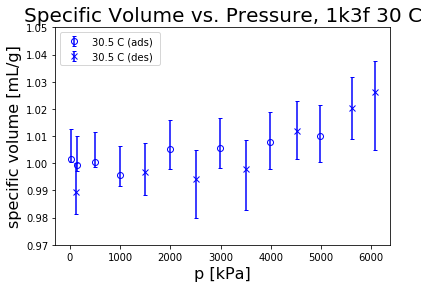

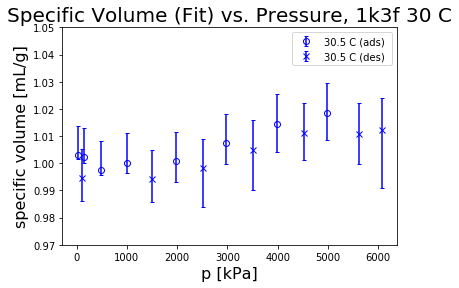

In [18]:
reload(errprop)
reload(plot)

# propagate error to estimate uncertainty, distinguishing statistical and systematic
s_spec_vol_stat, s_spec_vol_sys = errprop.error_spec_vol_stat_sys(spec_vol, v_samp, buoyancy, w_gas_act, v_drop_eq, 
                                    s_v_drop_eq,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)

# Plot specific volume vs. pressure, stat is bottom error bar, sys is top
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.97, 1.05])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol_fit, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                 title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.97, 1.05])

As for 60 C, we see that the specific volume dips slightly and then increases, but the noise in the volume measurement is much higher because the drop fell.

If we use the quadratic fit to estimate the volume of the sample, we see that the specific volume becomes non-monotonic, as observed when doing the same for 20190612_0617_1k2f_30c_analysis. The specific volume also slightly decreases above 5000 kPa, which was also observed in the 1k2f 30c analysis.

In [19]:
reload(dataproc)
# convert time from minutes to seconds
t_grav_sec = 60*t_grav
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav_sec, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('.csv')-1] + '_densities.csv', index=False)

### Interfacial Tension

At this point, I use the program `auto_density_input_fta32.py` to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

Pressure = 20 kPa.
Rejected 1 outliers.
Interfacial tension = 25.417500 mN/m.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 150 kPa.
Rejected 1 outliers.
Interfacial tension = 25.333500 mN/m.
Pressure = 500 kPa.
Rejected 1 outliers.
Interfacial tension = 24.527500 mN/m.
Pressure = 1000 kPa.
Rejected 1 outliers.
Interfacial tension = 23.496000 mN/m.
Pressure = 2000 kPa.
Rejected 1 outliers.
Interfacial tension = 20.825500 mN/m.
Pressure = 3000 kPa.
Rejected 1 outliers.
Interfacial tension = 17.976000 mN/m.
Pressure = 4000 kPa.
Rejected 1 outliers.
Interfacial tension = 14.964500 mN/m.
Pressure = 5000 kPa.
Rejected 1 outliers.
Interfacial tension = 11.729500 mN/m.
Pressure = 6100 kPa.
Rejected 1 outliers.
More than half nans, so interfacial tension data not stored.
Pressure = 5600 kPa.
Rejected 1 outliers.
More than half nans, so interfacial tension data not stored.
Pressure = 4500 kPa.
Rejected 1 outliers.
More than half nans, so interfacial tension data not stored.
Pressure = 3500 kPa.
Rejected 1 outliers.
could not analyze more interfacial tension data.
Pressure = 2500 kPa.
Rejected 1 outliers.


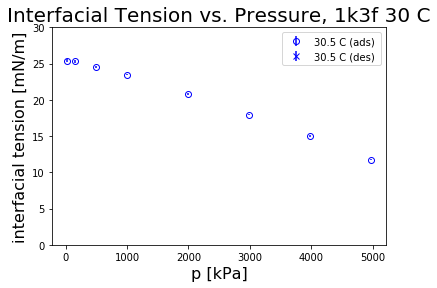

In [20]:
reload(dataproc)
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        try:
            p_set = p_set_arr[i]
            print('Pressure = %d kPa.' % p_set)

            # use a higher threshold on the fractional pressure fluctuation for 20 kPa
            if p_set == 20:
                p_thresh_frac_20 = 0.1
                i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac_20, last_bound=i_p1)

            else:
                i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
            # store data
            df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)
        except:
            print('could not analyze more interfacial tension data.')

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))
    ax.set_ylim([0, 30])

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

#### Fit Initial Time and Mass

Our first approach is to fit both the initial time of the sorption ($t_0$) and the initial mass ($M(t_0)$).

Pressure = 20 kPa.
Rejected 1 outliers.
D_sqrt = 3.23e-07 cm^2/s.
Pressure = 150 kPa.
Rejected 1 outliers.
D_sqrt = 6.96e-06 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 3.41e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 1.04e-05 cm^2/s.

C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:1640: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "



Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 5.71e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 7.86e-06 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 7.71e-06 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 7.51e-06 cm^2/s.
Pressure = 6100 kPa.
Rejected 1 outliers.
D_sqrt = 2.66e-06 cm^2/s.
Pressure = 5600 kPa.
Rejected 1 outliers.
D_sqrt = 5.98e-06 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_sqrt = 5.19e-06 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 1.13e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.01e-05 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 5.77e-06 cm^2/s.
Pressure = 110 kPa.
Rejected 1 outliers.
D_sqrt = 1.94e-07 cm^2/s.


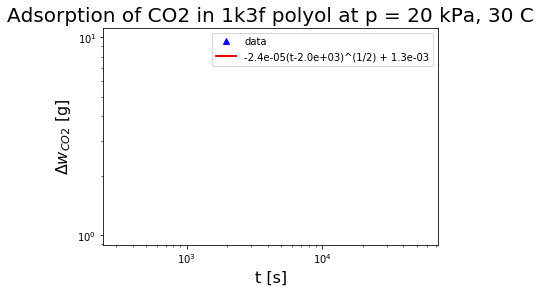

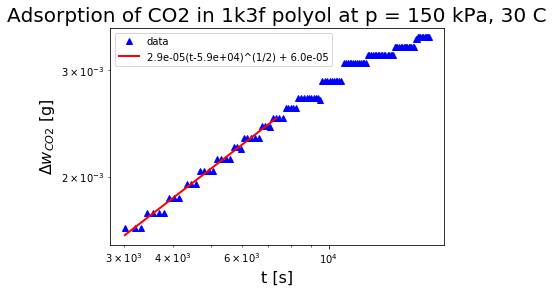

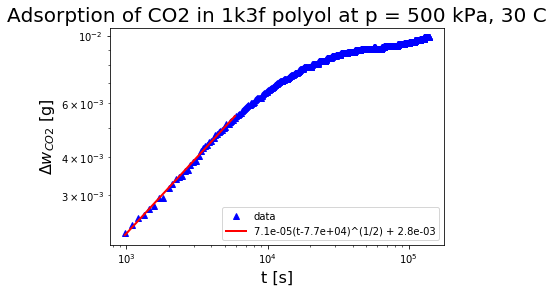

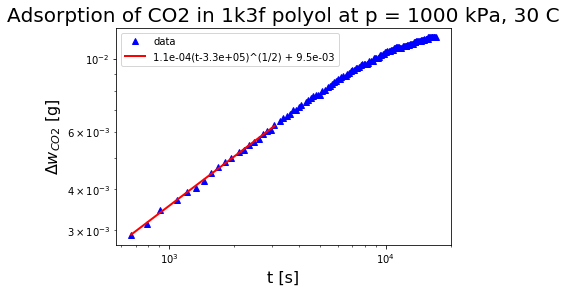

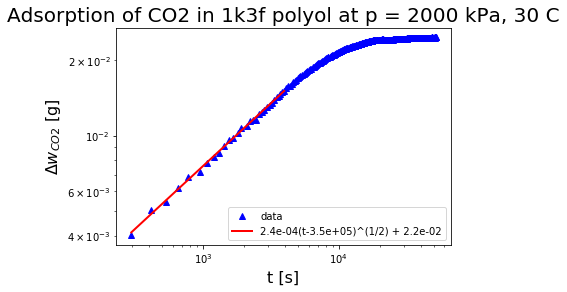

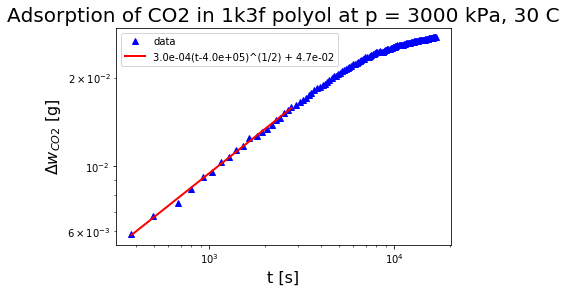

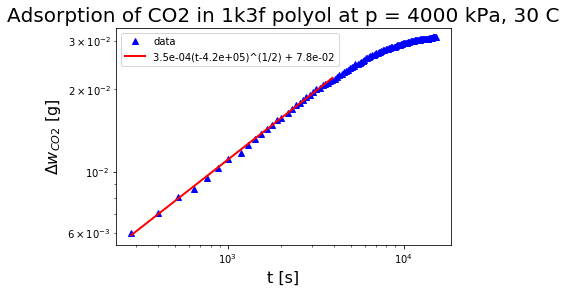

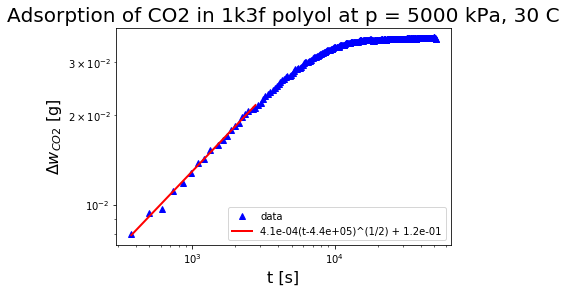

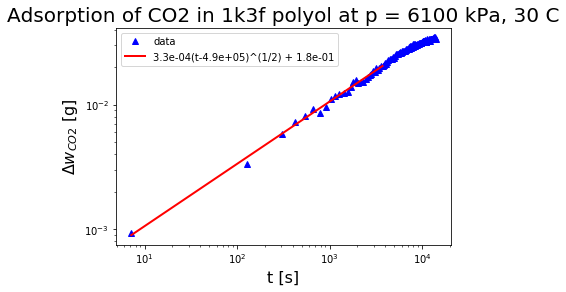

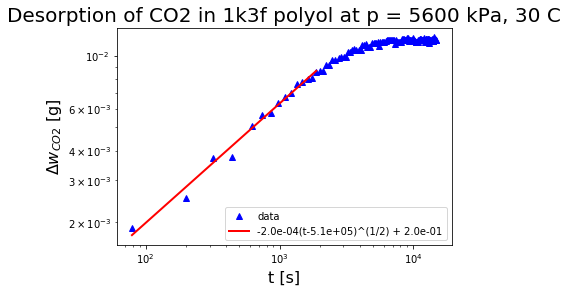

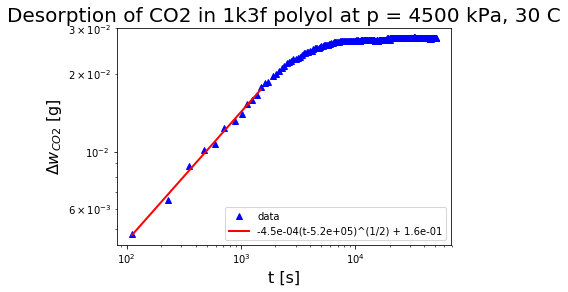

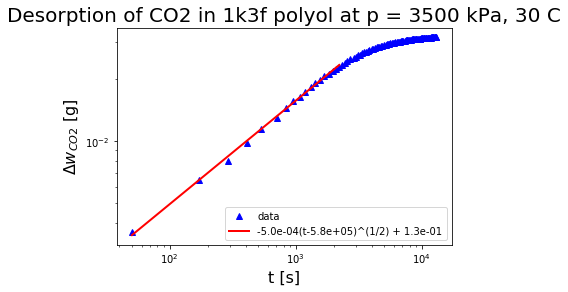

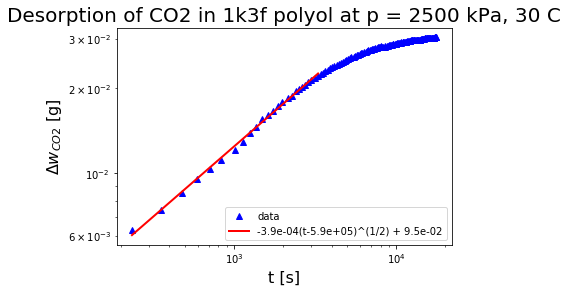

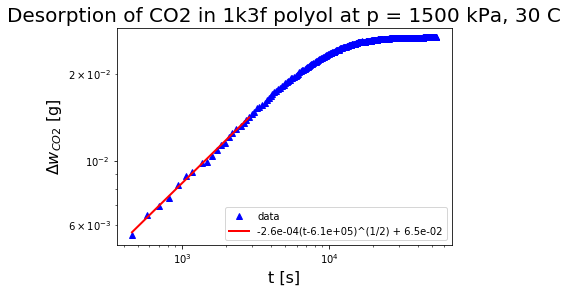

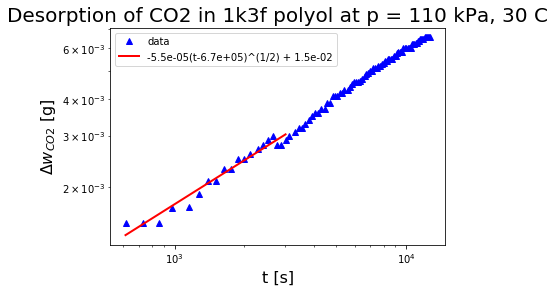

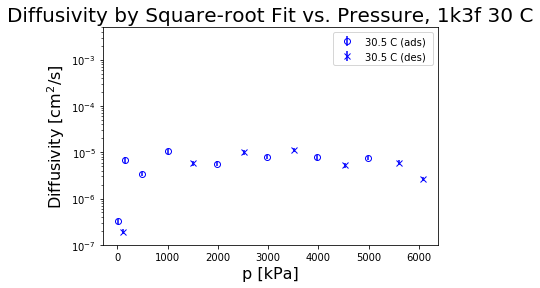

In [21]:
# FOR REFERENCE
# p_set_arr = array([  0:20.,  1:150.,  2:500., 3:1000., 4:2000., 5:3000., 6:4000., 7:5000., 8:6100.,
#        9:5600., 10:4500., 11:3500., 12:2500., 13:1500.,  14:110.])
reload(dataproc)
reload(plot)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 20*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[1] = 35
n_pts_sqrt_arr[2] = 40
n_pts_sqrt_arr[4] = 30
n_pts_sqrt_arr[6] = 30
n_pts_sqrt_arr[8] = 30
n_pts_sqrt_arr[9] = 15
n_pts_sqrt_arr[10] = 12
n_pts_sqrt_arr[11] = 18
n_pts_sqrt_arr[12] = 25

# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = 2*np.ones(len(p_set_arr)).astype(int)
i_shift[2] = 3
i_shift[8] = 8
i_shift[9] = 8


 # Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit both initial time t0 and initial mass w0 ***Note: use t_grav_sec so Diffusivity is in cm^2/s
D_sqrt_2fit_arr, M_0_extrap_2fit_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, polyol, 
                                                                                 T, p_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                                 p_thresh_frac, v_ref_he, i_shift, 
                                                                                 maxfev, diam_cruc, fit_t0=True, fit_w0=True)
# Define uncertainties for the first calculation
M_0 = df['M_0 (prev) [g]'].to_numpy(dtype=float)
M_infty = df['M_infty (final) [g]'].to_numpy(dtype=float)
s_M_0 = df['M_0 (prev) std [g]'].to_numpy(dtype=float)
s_M_infty = df['M_infty (final) std [g]'].to_numpy(dtype=float)

# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_2fit_arr = errprop.error_D_sqrt(D_sqrt_2fit_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_2fit_arr, s_D_sqrt_2fit_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 5E-3],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_2fit_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The fits are quite poor at 5600 kPa and 6100 kPa, but the values seem reasonable given that we could not collect data points with as much precision using Datathief on the Belsorp's output plots.

#### Fit Initial Mass

Next we will estimate the diffusivity by fitting the initial mass at the initial time $t_0$ but estimating the initial time $t_0$ as the last time point of the previous pressure step.

Pressure = 20 kPa.
Rejected 1 outliers.
D_sqrt = 3.00e-07 cm^2/s.
Pressure = 150 kPa.
Rejected 1 outliers.
D_sqrt = 8.12e-06 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 3.77e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 6.99e-04 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 8.85e-06 cm^2/s.


C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 1.36e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 1.23e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 1.39e-05 cm^2/s.
Pressure = 6100 kPa.
Rejected 1 outliers.
D_sqrt = 8.20e-06 cm^2/s.
Pressure = 5600 kPa.
Rejected 1 outliers.
D_sqrt = 2.14e-05 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_sqrt = 2.02e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 3.43e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.73e-05 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 8.96e-06 cm^2/s.
Pressure = 110 kPa.
Rejected 1 outliers.
D_sqrt = 1.53e-06 cm^2/s.


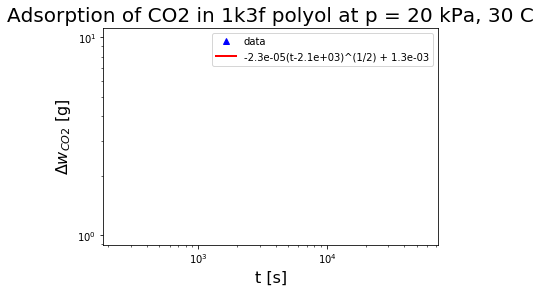

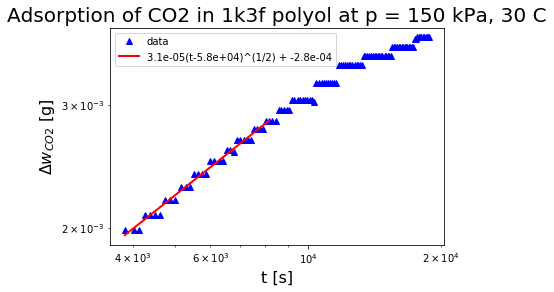

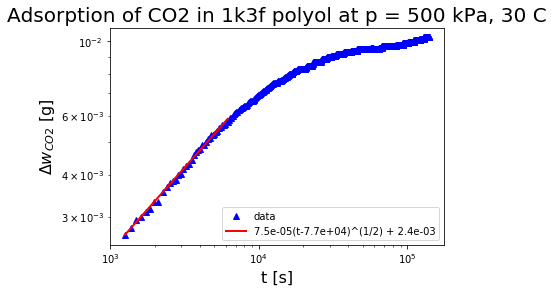

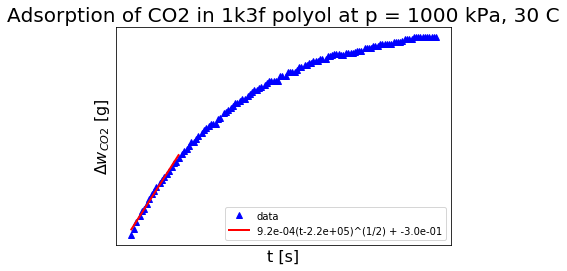

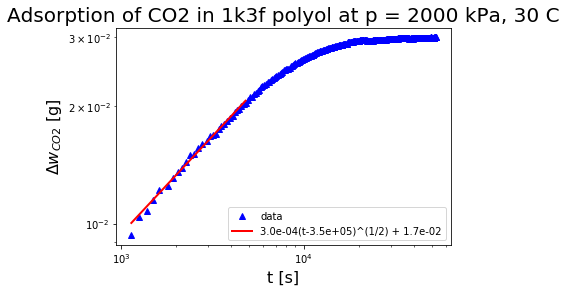

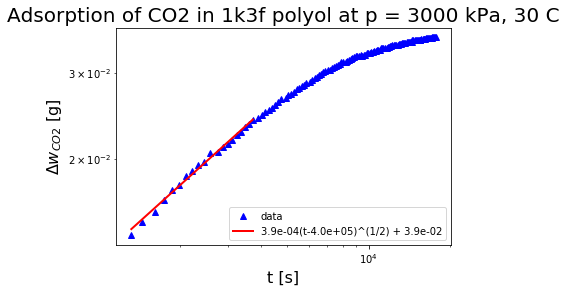

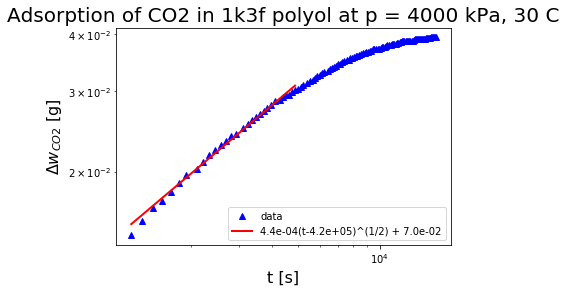

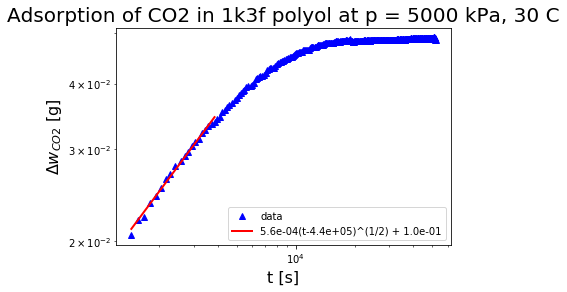

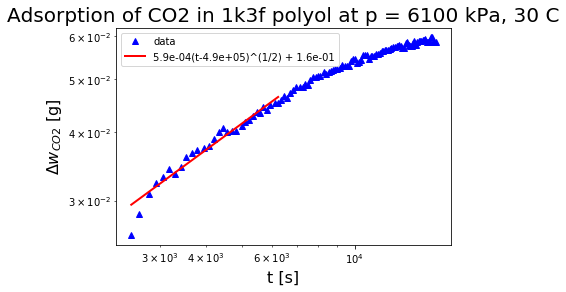

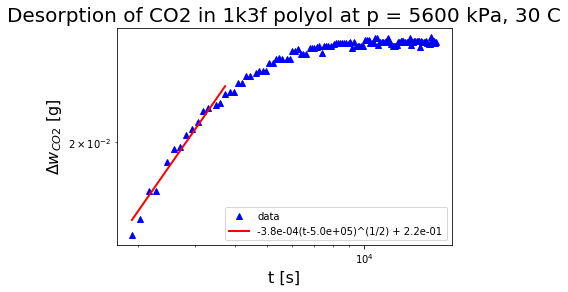

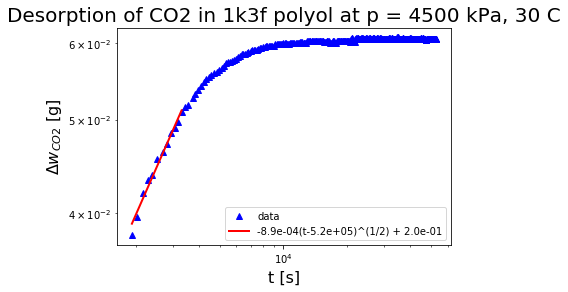

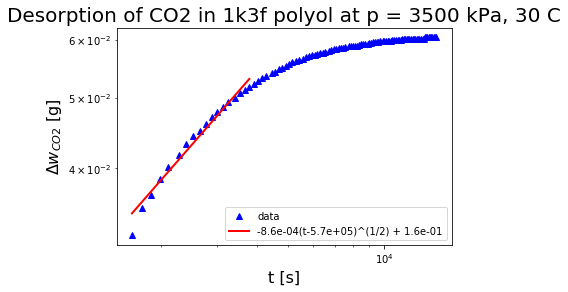

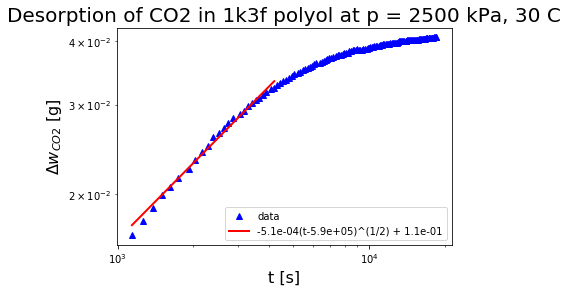

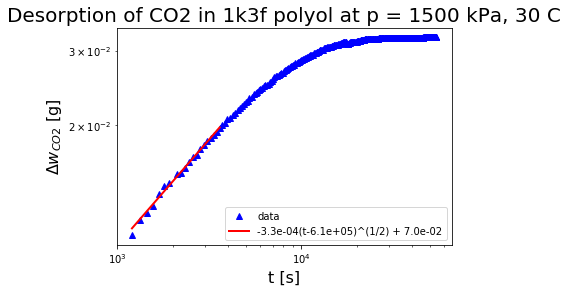

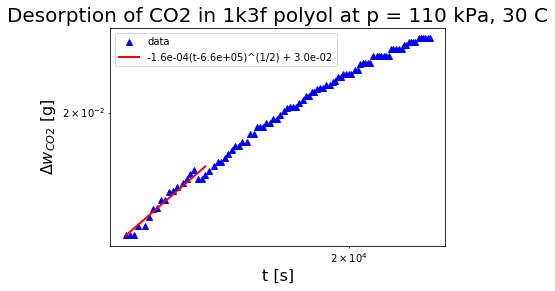

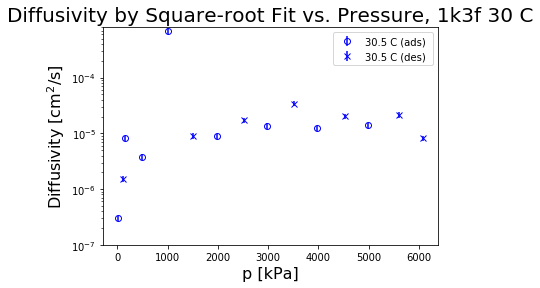

In [22]:
# FOR REFERENCE
# p_set_arr = array([  0:20.,  1:150.,  2:500., 3:1000., 4:2000., 5:3000., 6:4000., 7:5000., 8:6100.,
#        9:5600., 10:4500., 11:3500., 12:2500., 13:1500.,  14:110.])

# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit initial mass but use last time point of previous experiment as initial time t0 ***Use t_grav_sec
D_sqrt_fitw0_arr, M_0_extrap_fitw0_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=False, fit_w0=True)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fitw0_arr = errprop.error_D_sqrt(D_sqrt_fitw0_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitw0_arr, s_D_sqrt_fitw0_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 8E-4],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fitw0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The fits do not look as good but the results are still reasonable, except for pressure of 1000 kPa where the diffusivity is over an order of magnitude higher than before. This anomaly may be a result of a poor estimate of the fixed initial mass used in this fitting.

#### Fit Initial Time

In this rendition of the diffusivity calculation, we fit the initial time $t_0$ and estimate the mass at the initial time $M(t_0)$ to be the mass of gas measured at the end of the previous pressure step.

Pressure = 20 kPa.
Rejected 1 outliers.
D_sqrt = 3.84e-06 cm^2/s.
Pressure = 150 kPa.
Rejected 1 outliers.
D_sqrt = 4.27e-06 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 2.83e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:1650: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)


Square-root fit could not converge.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 6.16e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 8.34e-06 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 9.87e-06 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 1.12e-05 cm^2/s.
Pressure = 6100 kPa.
Rejected 1 outliers.
D_sqrt = 9.64e-06 cm^2/s.
Pressure = 5600 kPa.
Rejected 1 outliers.
D_sqrt = 2.09e-05 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_sqrt = 1.84e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 1.80e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.12e-05 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 6.07e-06 cm^2/s.
Pressure = 110 kPa.
Rejected 1 outliers.
D_sqrt = 2.18e-06 cm^2/s.


C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


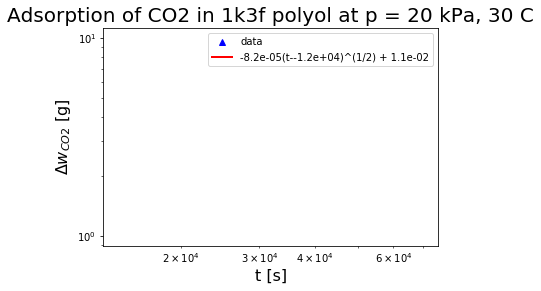

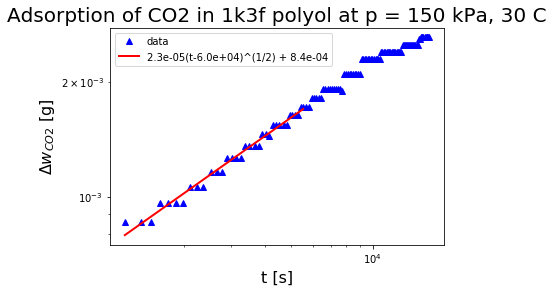

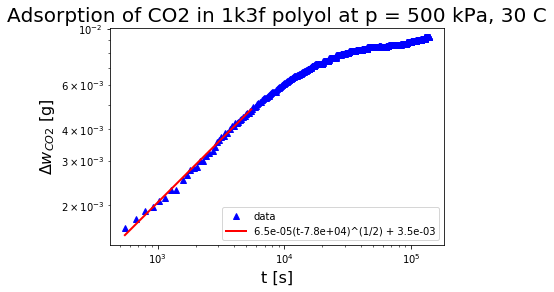

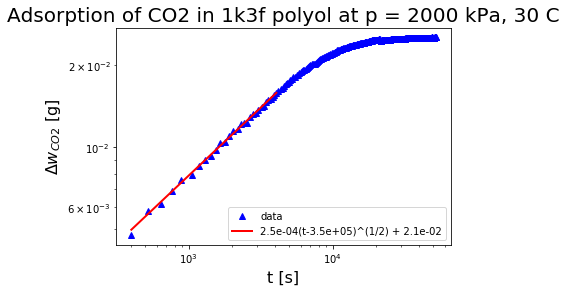

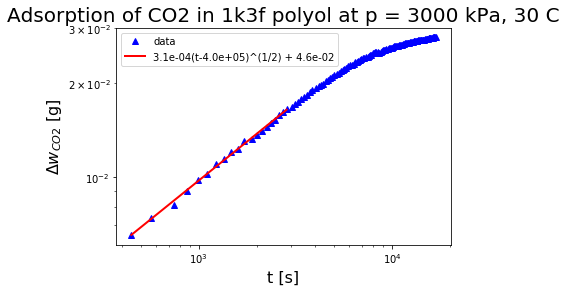

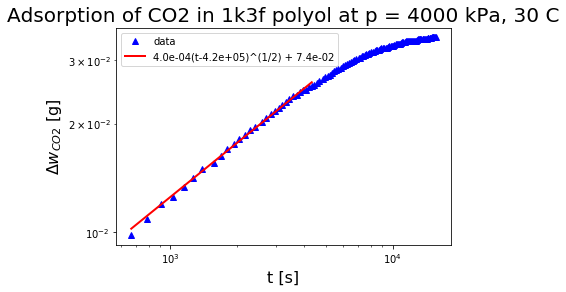

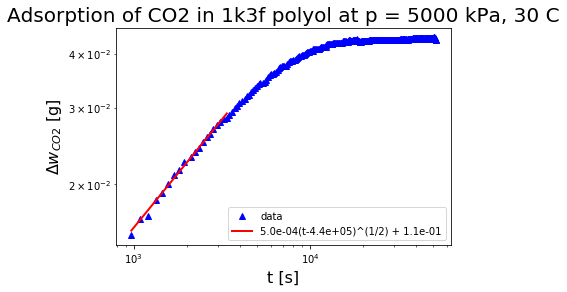

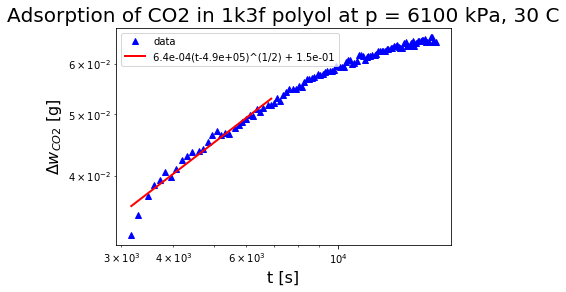

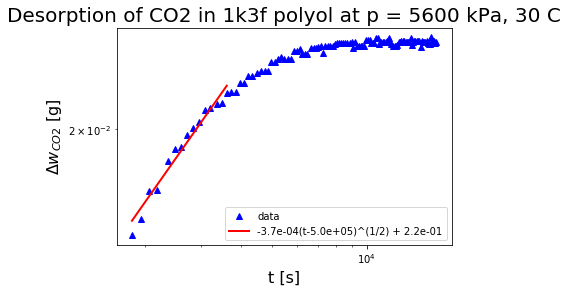

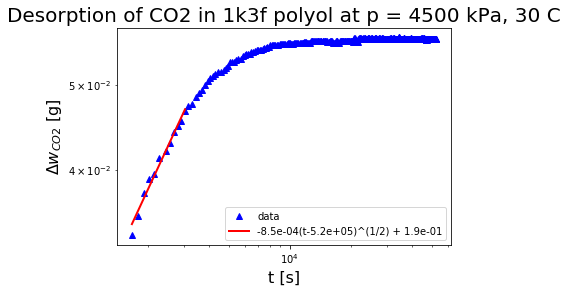

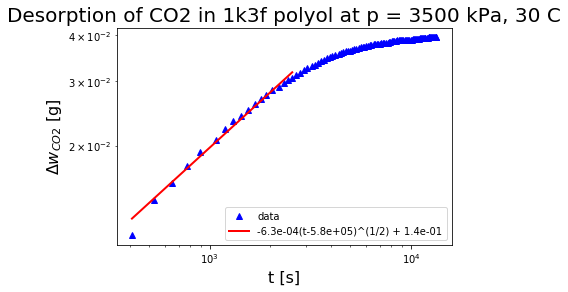

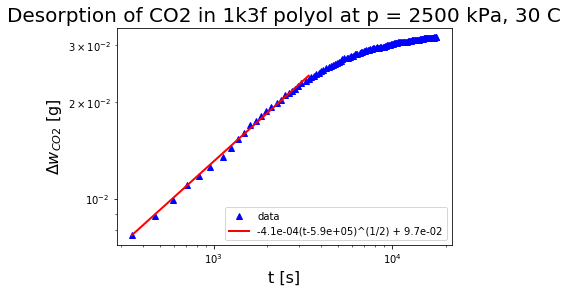

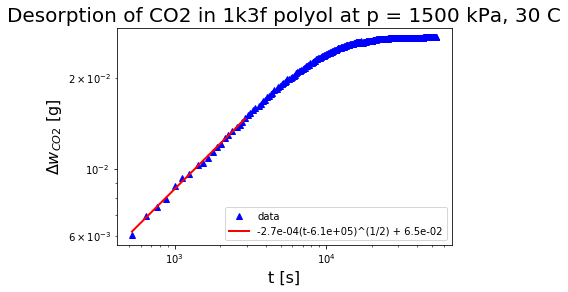

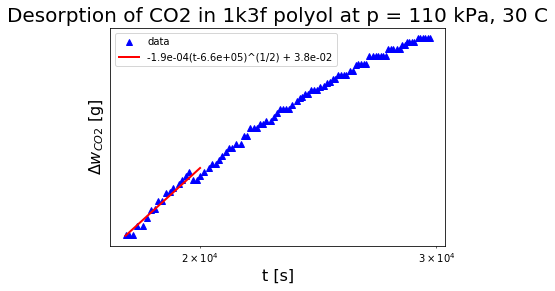

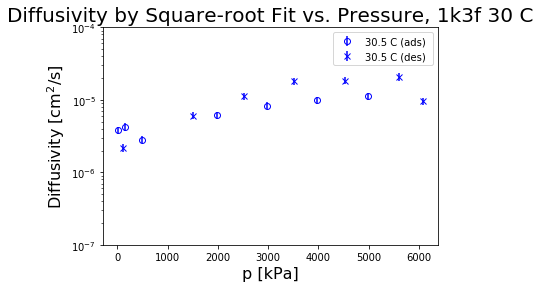

In [23]:
# FOR REFERENCE
# p_set_arr = array([  0:20.,  1:150.,  2:500., 3:1000., 4:2000., 5:3000., 6:4000., 7:5000., 8:6100.,
#        9:5600., 10:4500., 11:3500., 12:2500., 13:1500.,  14:110.])

n_pts_sqrt_arr[3] = 15
# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit initial mass but use last time point of previous experiment as initial time t0 ***use t_grav_sec
D_sqrt_fitt0_arr, M_0_extrap_fitt0_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=True, fit_w0=False)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fitt0_arr = errprop.error_D_sqrt(D_sqrt_fitt0_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 1E-4],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fitt0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

Once again, some poor fits (e.g. 1000 kPa) but reasonable results. The data even show a slight increase with pressure, as expected due to the reduction of viscosity with the adsorption of more CO2.

#### Fix (Not Fit) the Initial Mass and Initial Time

As a final comparison, we calculate the diffusivity using estimates of the initial time and mass from the experiment, where the initial time is the last time point measured in the previous pressure step and the initial mass of adsorbed gas is that at the end of the previous pressure step.

Pressure = 20 kPa.
Rejected 1 outliers.
D_sqrt = 3.92e-05 cm^2/s.
Pressure = 150 kPa.
Rejected 1 outliers.
D_sqrt = 2.38e-06 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_sqrt = 2.28e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 1.05e-08 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_sqrt = 4.60e-06 cm^2/s.


C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


Pressure = 3000 kPa.
Rejected 1 outliers.
D_sqrt = 5.44e-06 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 8.12e-06 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 9.20e-06 cm^2/s.
Pressure = 6100 kPa.
Rejected 1 outliers.
D_sqrt = 1.11e-05 cm^2/s.
Pressure = 5600 kPa.
Rejected 1 outliers.
D_sqrt = 2.01e-05 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_sqrt = 1.66e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_sqrt = 9.83e-06 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 7.77e-06 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_sqrt = 4.33e-06 cm^2/s.
Pressure = 110 kPa.
Rejected 1 outliers.
D_sqrt = 3.11e-06 cm^2/s.


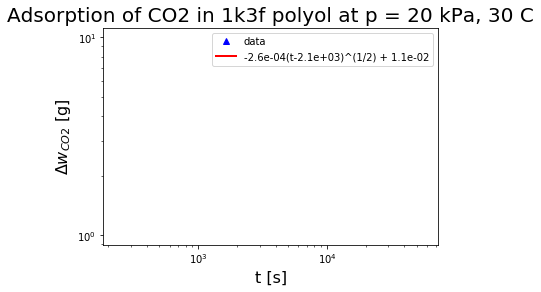

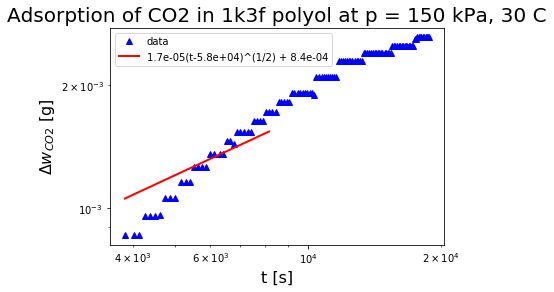

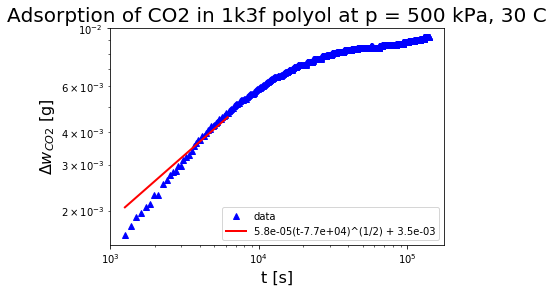

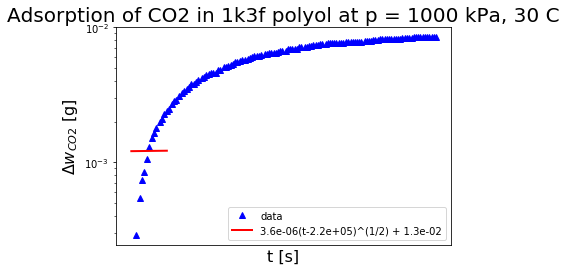

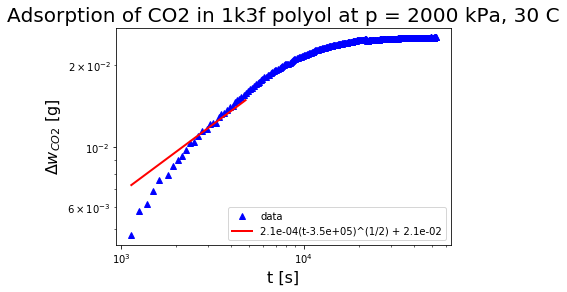

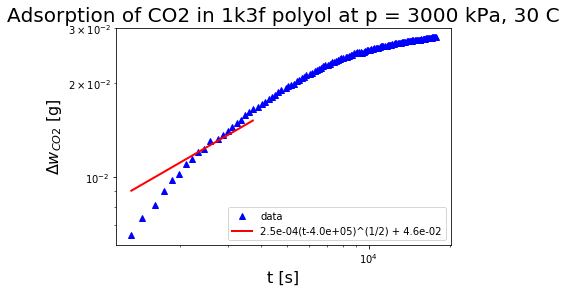

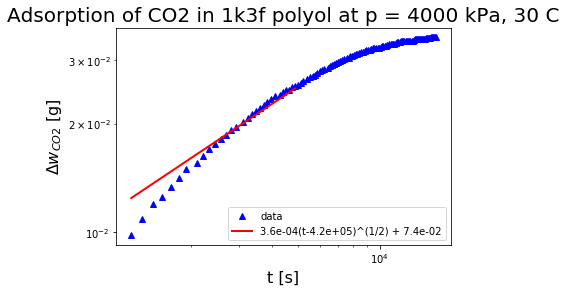

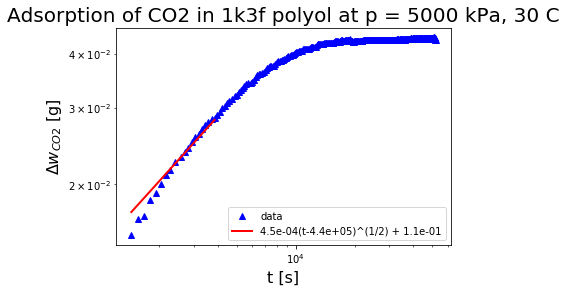

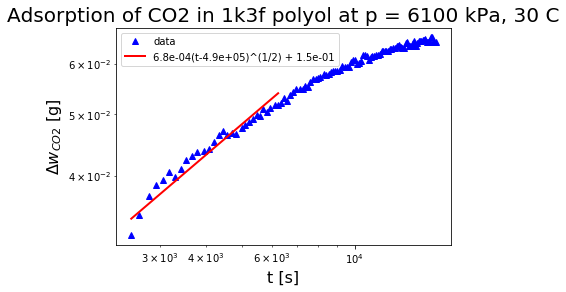

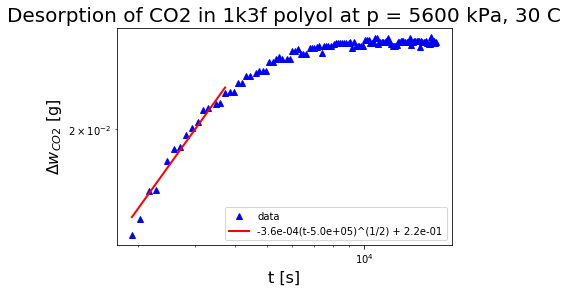

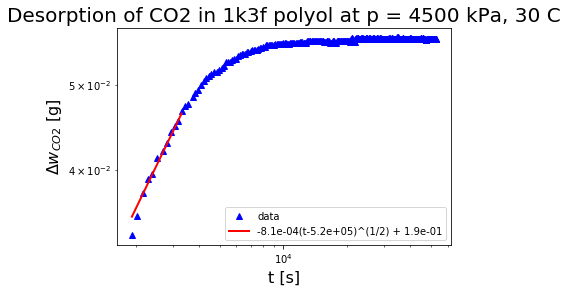

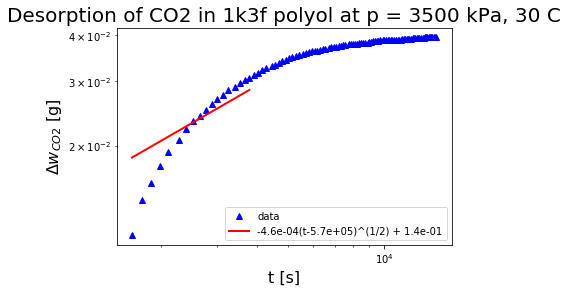

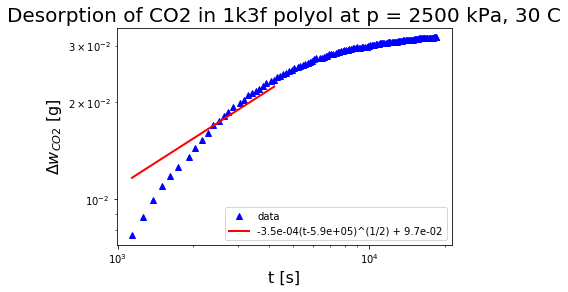

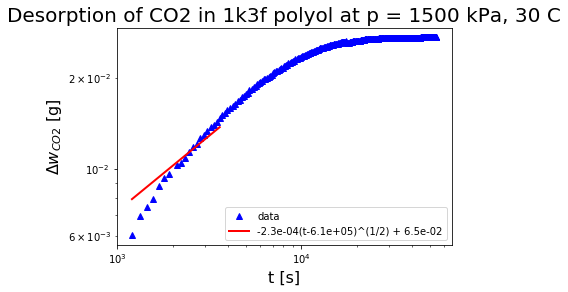

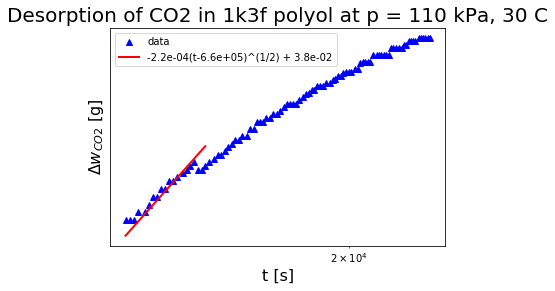

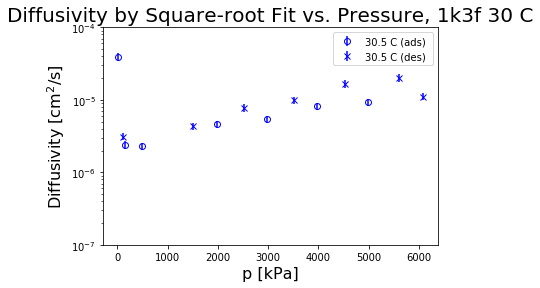

In [24]:
# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# use time and mass at end of previous pressure step as estiamtes of initial time and mass ***use t_grav_sec
D_sqrt_fixed_arr, M_0_extrap_fixed_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=False, fit_w0=False)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fixed_arr = errprop.error_D_sqrt(D_sqrt_fixed_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fixed_arr, s_D_sqrt_fixed_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 1E-4],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fixed_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The model poorly fits the data for many cases. Given that the model fits the data when the initial time and/or mass are not fixed, we believe that the empirical estimates for the initial mass and time are poor.

The agreement between the theory and the data is much worse when the theory is not fit to the data, suggesting that our estimation of at least one of the initial mass and the initial time is erroneous.

#### Compare Different Types of Square-root Fits

Below we compare the diffusivities calculated using each of the fits considered above.

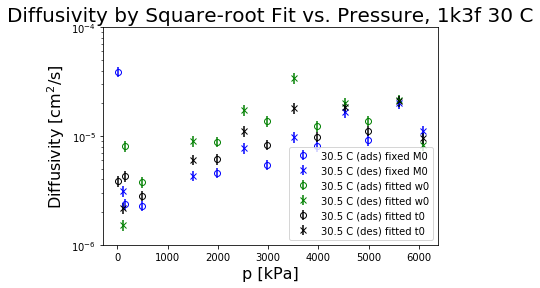

In [25]:
# Plot diffusivity vs. pressure for fixed M_0 and t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fixed_arr, s_D_sqrt_fixed_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='fixed M0',
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# Plot diffusivity vs. pressure for fitted M_0 and fixed t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitw0_arr, s_D_sqrt_fitw0_arr, p_set_arr, T, ax=ax, color='g',
                                label_tag='fitted w0') 
# Plot diffusivity vs. pressure for fixed M_0 and fitted t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, ax=ax, 
                                 color='k', label_tag='fitted t0') 

save_plots=False
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_comparison_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Save Results

The fitted t0 values fall in the middle of all the estimated values and are not too widely varying besides the value at 1000 kPa, which is not very accurately estimated by the other methods either. For this reason, we will save those values as the results from the square-root fit.

In [26]:
# save results to dataframe
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_fitt0_arr
df['diffusivity (sqrt) std [cm^2/s]'] = s_D_sqrt_fitt0_arr
df['M_0 (extrap) [g]'] = M_0_extrap_fitt0_arr

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

*Note that the change in $h_{samp}$ during the course of a pressure step is negligible relative to the error in the fitted parameter $B$ (at most 2%).*

Pressure = 20 kPa.
Rejected 1 outliers.
D_exp = 4.66e-10 cm^2/s.
Pressure = 150 kPa.
Rejected 1 outliers.
D_exp = 4.28e-06 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.
D_exp = 1.53e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_exp = 5.00e-06 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_exp = 6.85e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_exp = 8.60e-06 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_exp = 9.11e-06 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_exp = 3.25e-05 cm^2/s.
Pressure = 6100 kPa.
Rejected 1 outliers.
D_exp = 4.60e-04 cm^2/s.
Pressure = 5600 kPa.
Rejected 1 outliers.
D_exp = 4.06e-05 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_exp = 2.78e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_exp = 1.97e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_exp = 1.22e-05 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_exp = 6.14e-06 cm^2/s.
Pressure = 110 kPa.
Rejected 1 outliers.
D_exp = 3.43e-06 cm^2/s.


C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:466: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


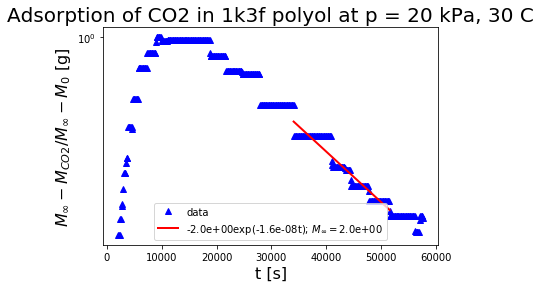

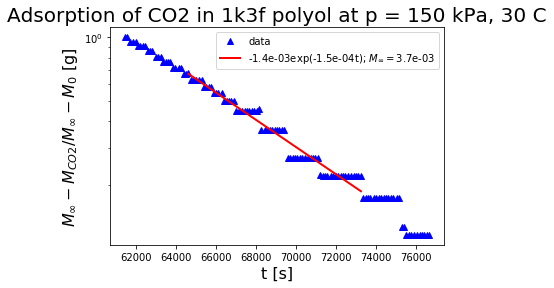

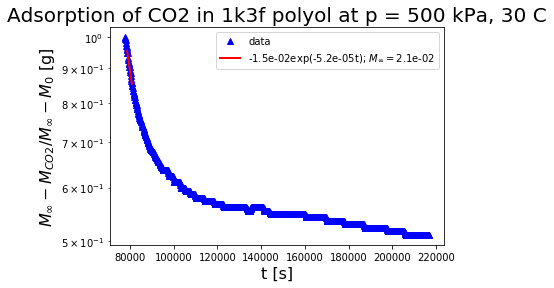

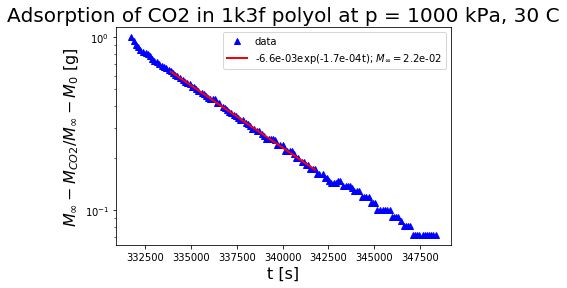

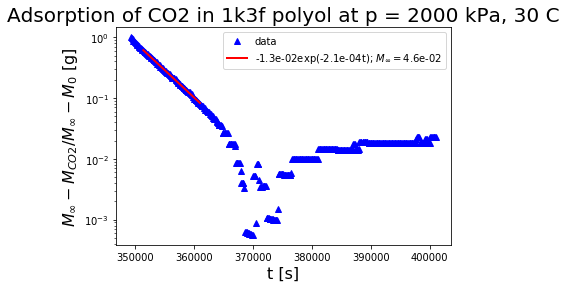

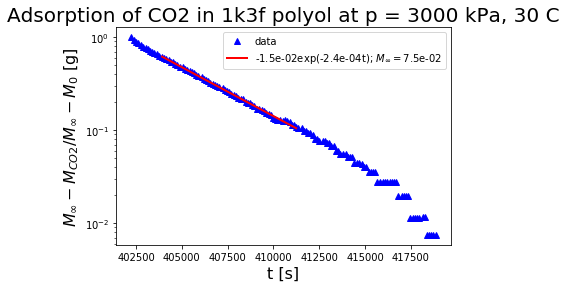

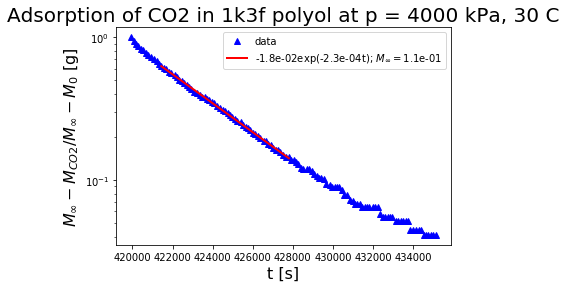

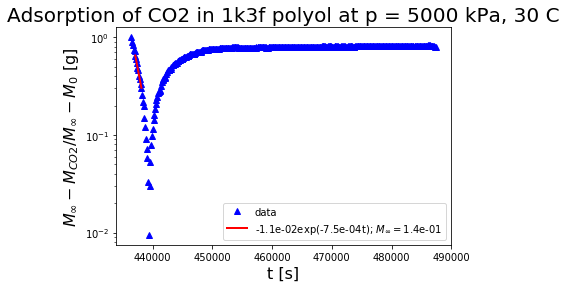

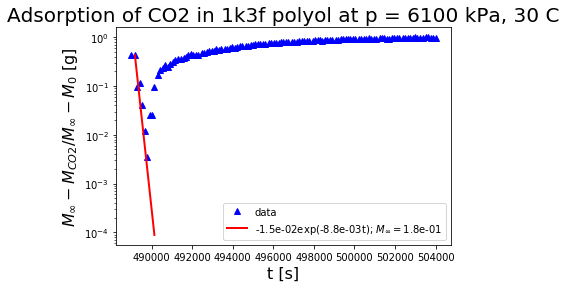

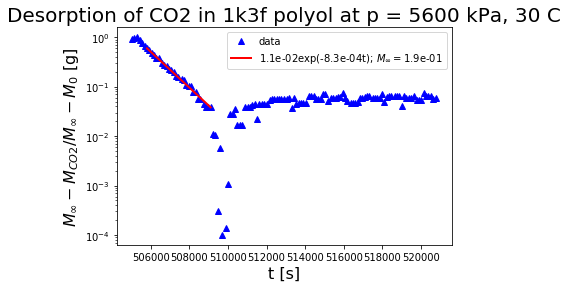

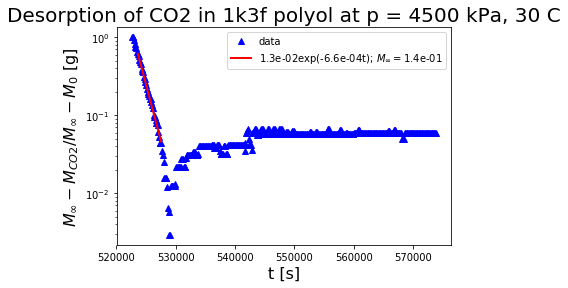

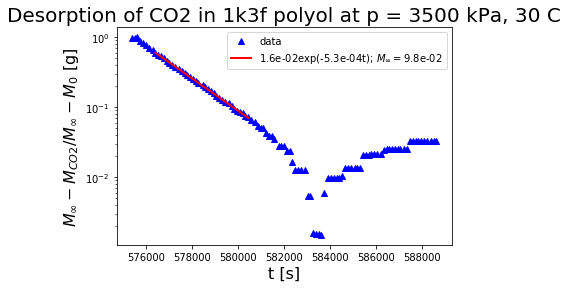

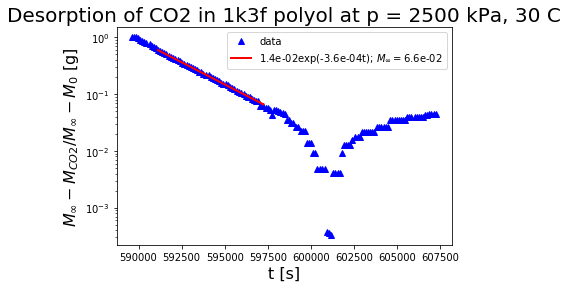

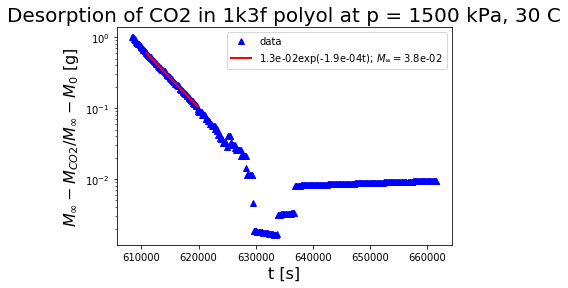

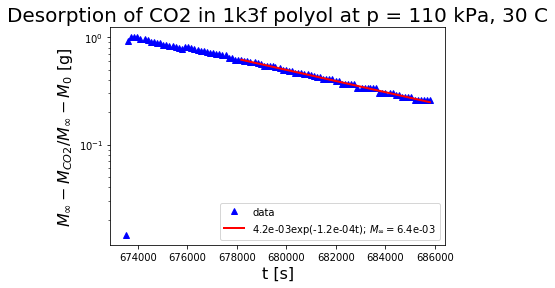

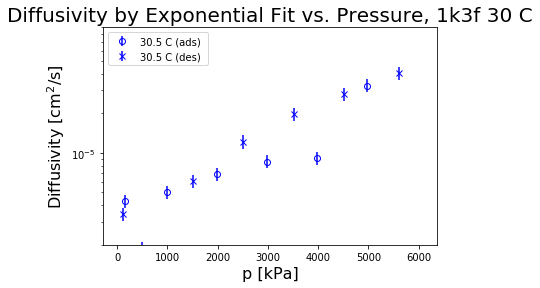

In [27]:
# FOR REFERENCE
# p_set_arr = array([  0:20.,  1:150.,  2:500., 3:1000., 4:2000., 5:3000., 6:4000., 7:5000., 8:6100.,
#        9:5600., 10:4500., 11:3500., 12:2500., 13:1500.,  14:110.])

# thresholds for fraction of remaining gas mass to include in fit
thresh0_arr = 0.6*np.ones([len(p_set_arr)])
thresh1_arr = 0.1*np.ones([len(p_set_arr)])
# individual thresholds
thresh0_arr[2] = 0.9 # 500
thresh1_arr[2] = 0.7 # 500
thresh0_arr[7] = 0.8 # 5000
thresh1_arr[7] = 0.6 # 5000
thresh0_arr[8] = 0.9 # 6100
thresh1_arr[8] = 0.6 # 6100


# list of terms used for computing errors in results
err_list = [v_samp, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, 
            v_drop_ref, s_v_drop_ref]

# compute diffusivity [cm^2/s] with exponential fit, uncertainty [cm^2/s], mass at infinite time [g], and time constant [s]
D_exp_arr, s_D_exp_arr, M_infty_arr, tau_arr = dataproc.diffusivity_exp(p_set_arr, thresh0_arr, thresh1_arr, t_grav_sec, 
                                                                        polyol, T, p_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        p_thresh_frac, v_ref_he, diam_cruc, err_list)

# record diffusivity and uncertainty calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
df['diffusivity (exp) std [cm^2/s]'] = s_D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, s_D_exp_arr, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([2E-6,9E-5])
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The fit for 6100 kPa is strange, but the results seem reasonable. The only discrepancy is there is some hysteresis between 2000-4000 kPa between adsorption and desorption measurements, which is not surprising given that this experiment was some what rushed after August 5th (the beginning of my final week in Naples).

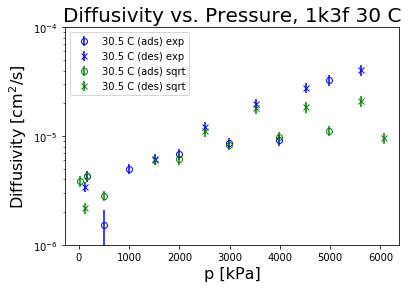

In [28]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, s_D_exp_arr, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', label_tag='exp',
                                 title='Diffusivity vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, ax=ax, color='g', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='sqrt')
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# save figure
save_plots = True
if save_plots:
    plt.savefig(save_folder + 'diff_exp_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

There is close agreement between the exponential and square-rooting fitting methods for all but the very low pressures and the highest pressure, suggesting that these are reliable estimates of the diffusivity.